In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import matplotlib.pyplot as plt

0. Set Hyperparamters

In [2]:
train_ratio = 0.8
validation_ratio = 0.2
epochs = 1000
batch_size = 1024

1. Import Data

In [3]:
def remove_outliers_z_score(df, threshold=2):
    z_scores = (df - df.mean()) / df.std()
    outliers = (z_scores.abs() > threshold).any(axis=1)
    return df[~outliers]

In [30]:
# 1. Import data
NY_data = pd.read_csv("data/NY_data.csv")

# 2. Remove outliers based on z-score
NY_data = remove_outliers_z_score(NY_data)

# 3. Split data into x and y values
y = NY_data['price']
X = NY_data.drop(columns=['price'])

# 4. One Hot Encode Zip Codes
X['zip_code'] = X['zip_code'].astype(str)
df_encoded = pd.get_dummies(X, columns=['zip_code'])

print(df_encoded)

# 5. Split data into Train vs. Test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_ratio, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_ratio, random_state=42)

# 6. Normalize data
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_train_norm = X_scaler.fit_transform(X_train)
X_val_norm = X_scaler.transform(X_val)
X_test_norm = X_scaler.transform(X_test)

y_train_norm = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_val_norm = y_scaler.transform(y_val.values.reshape(-1, 1))
y_test_norm = y_scaler.transform(y_test.values.reshape(-1, 1))

       bed  bath  acre_lot  house_size  zip_code_10023.0  zip_code_10024.0  \
0      3.0   1.0     60.00      1176.0             False             False   
1      3.0   2.0      2.02      1600.0             False             False   
2      4.0   2.0      0.24      1239.0             False             False   
3      3.0   3.0      1.90      1800.0             False             False   
4      3.0   2.0      2.00      1482.0             False             False   
...    ...   ...       ...         ...               ...               ...   
50750  4.0   2.0      0.20      1895.0             False             False   
50751  2.0   1.0     32.76      1100.0             False             False   
50752  4.0   2.0      0.25      1428.0             False             False   
50753  3.0   2.0      9.63      1488.0             False             False   
50754  3.0   2.0      0.48      1200.0             False             False   

       zip_code_10025.0  zip_code_10026.0  zip_code_10027.0  zi

In [246]:
DNN = tf.keras.models.Sequential([
    tf.keras.layers.Dense(6, input_dim=X.shape[1], activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dense(1)
])

early_stop = tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)

DNN.compile(loss='mse', optimizer='adam')

2. Model Initilization

In [247]:
history = DNN.fit(X_train_norm, y_train_norm, epochs=epochs, verbose=1, batch_size=batch_size, validation_data=(X_val_norm, y_val_norm), callbacks=[early_stop])

Epoch 1/1000
30/30 [==============================] - 2s 18ms/step - loss: 0.9710 - val_loss: 0.9043
Epoch 2/1000
30/30 [==============================] - 0s 13ms/step - loss: 0.8800 - val_loss: 0.8645
Epoch 3/1000
30/30 [==============================] - 0s 12ms/step - loss: 0.8351 - val_loss: 0.8172
Epoch 4/1000
30/30 [==============================] - 0s 13ms/step - loss: 0.7872 - val_loss: 0.7699
Epoch 5/1000
30/30 [==============================] - 0s 12ms/step - loss: 0.7388 - val_loss: 0.7182
Epoch 6/1000
30/30 [==============================] - 0s 12ms/step - loss: 0.6897 - val_loss: 0.6707
Epoch 7/1000
30/30 [==============================] - 0s 12ms/step - loss: 0.6408 - val_loss: 0.6226
Epoch 8/1000
30/30 [==============================] - 0s 12ms/step - loss: 0.5932 - val_loss: 0.5771
Epoch 9/1000
30/30 [==============================] - 0s 12ms/step - loss: 0.5480 - val_loss: 0.5351
Epoch 10/1000
30/30 [==============================] - 0s 12ms/step - loss: 0.5048 - val_lo

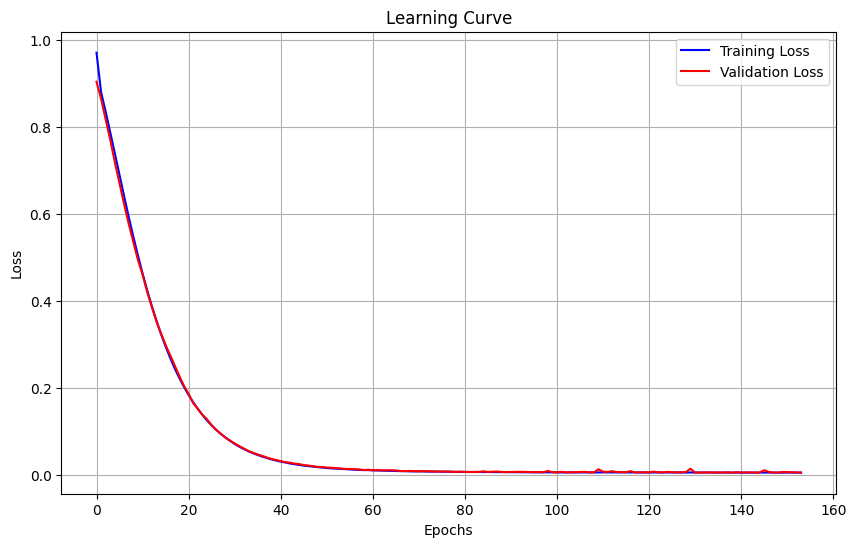

In [248]:
import matplotlib.pyplot as plt

# Extract the training and validation loss from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='red')
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [249]:
loss = DNN.evaluate(X_test_norm, y_test_norm)
print("Test Loss:", loss)

295/295 [==============================] - 0s 761us/step - loss: 0.0048
Test Loss: 0.004760608077049255


In [250]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = y_scaler.inverse_transform(DNN.predict(X_test_norm))
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

295/295 [==============================] - 0s 709us/step
Mean Absolute Error: 174260.16173581293
Mean Squared Error: 83762498121.4304
Root Mean Squared Error: 289417.51522917615
R-squared: 0.6274441120816732


In [228]:
predictions = DNN.predict(X_test_norm)
predictions = y_scaler.inverse_transform(predictions)


print("Example:")
print("Expected Prices:", ", ".join(str(expected) for expected in y_test.iloc[:5]))
print("Predicted Prices:", " ".join(str(predicted) for predicted in predictions[:5, 0]))

295/295 [==============================] - 0s 647us/step
Example:
Expected Prices: 160000.0, 250000.0, 409000.0, 525000.0, 1948000.0
Predicted Prices: 105214.6 270864.03 508434.97 296819.84 1156692.4
